# Kuairec dataset
Source: https://kuairec.com/

In [1]:
# Change this line to read from desired file

In [2]:
import sys

In [3]:
sys.path.append("/home/gerardoduran/documents/low-rank-last-layer-inference/experiments/")

In [4]:
cd "~/documents/KuaiRec 2.0"

/home/gerardoduran/documents/KuaiRec 2.0


/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [7]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [8]:
%config InlineBackend.figure_format = "retina"

In [9]:
video_stats = pd.read_csv("./data/item_daily_features.csv")

# Shift features by one day
new_dates = pd.to_datetime(video_stats["date"].astype(str)) - pd.Timedelta(days=1)
video_stats["date"] = new_dates.apply(lambda x: int(x.strftime("%Y%m%d")))

In [10]:
target_cols = ["video_id", "date", "like_cnt", "share_cnt", "play_cnt", "comment_cnt"]
video_stats[target_cols]

,video_id,date,like_cnt,share_cnt,play_cnt,comment_cnt
0,0,20200704,573,2,10141,11
1,0,20200705,302,1,7321,7
2,0,20200706,205,1,4757,4
3,0,20200707,297,2,5172,4
4,0,20200708,307,0,5392,5
...,...,...,...,...,...,...
343336,10723,20200904,24,0,214,0
343337,10724,20200904,264,1,965,29
343338,10725,20200904,851,3,15487,36
343339,10726,20200904,44,1,7859,0


In [11]:
cols_merge = ["video_id", "date"]
small_matrix = pd.read_csv("data/small_matrix.csv").dropna()
small_matrix = small_matrix.merge(video_stats[target_cols], on=cols_merge)
small_matrix.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,like_cnt,share_cnt,play_cnt,comment_cnt
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,3485,72,578125,626
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,9478,67,481643,168
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,24073,807,1230980,462
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,77044,500,1353520,1341
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,6404,23,475632,339


<Axes: xlabel='watch_ratio', ylabel='Count'>

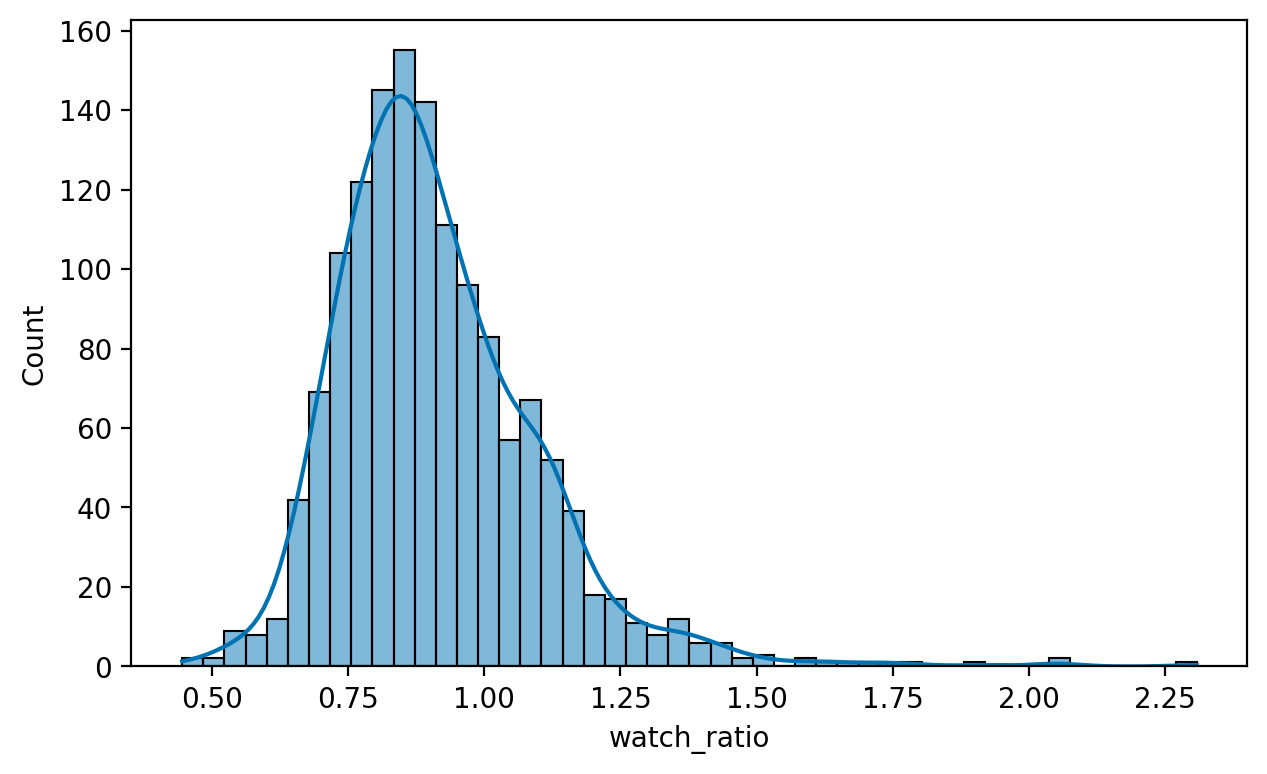

In [12]:
sns.histplot(small_matrix.groupby("user_id")["watch_ratio"].mean(), kde=True)

<Axes: xlabel='watch_ratio', ylabel='Count'>

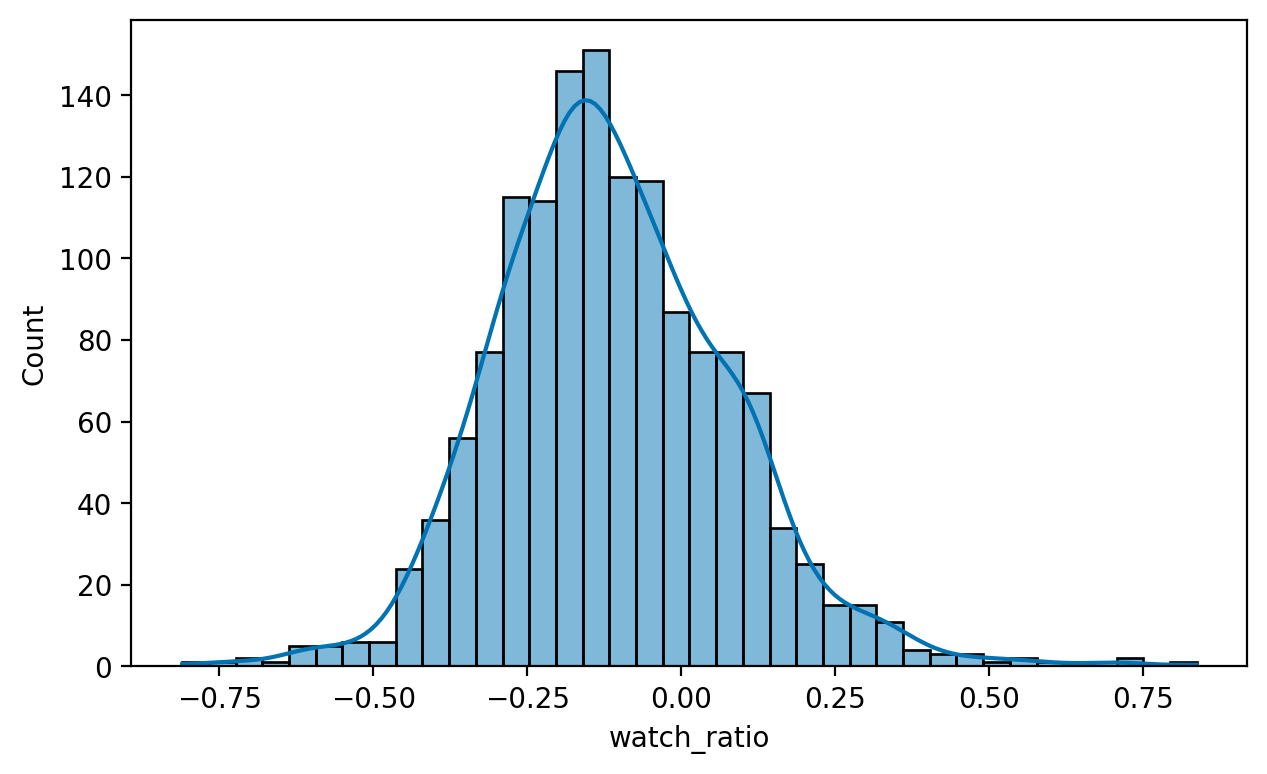

In [13]:
sns.histplot(np.log(small_matrix.groupby("user_id")["watch_ratio"].mean()), kde=True)

## Parse dataset

In [14]:
%%time
small_matrix_sub = small_matrix.dropna(subset="date")
small_matrix_sub = small_matrix_sub.assign(time=pd.to_datetime(small_matrix_sub["time"]))

unique_videos = small_matrix_sub["video_id"].unique()

# Encode new id for Embedding layer
id_to_ix_video = {id.item(): i for i, id in enumerate(unique_videos)}
small_matrix_sub = small_matrix_sub.assign(video_id=small_matrix_sub["video_id"].apply(lambda x: id_to_ix_video[x]))

CPU times: user 3.08 s, sys: 88 ms, total: 3.17 s
Wall time: 3.17 s


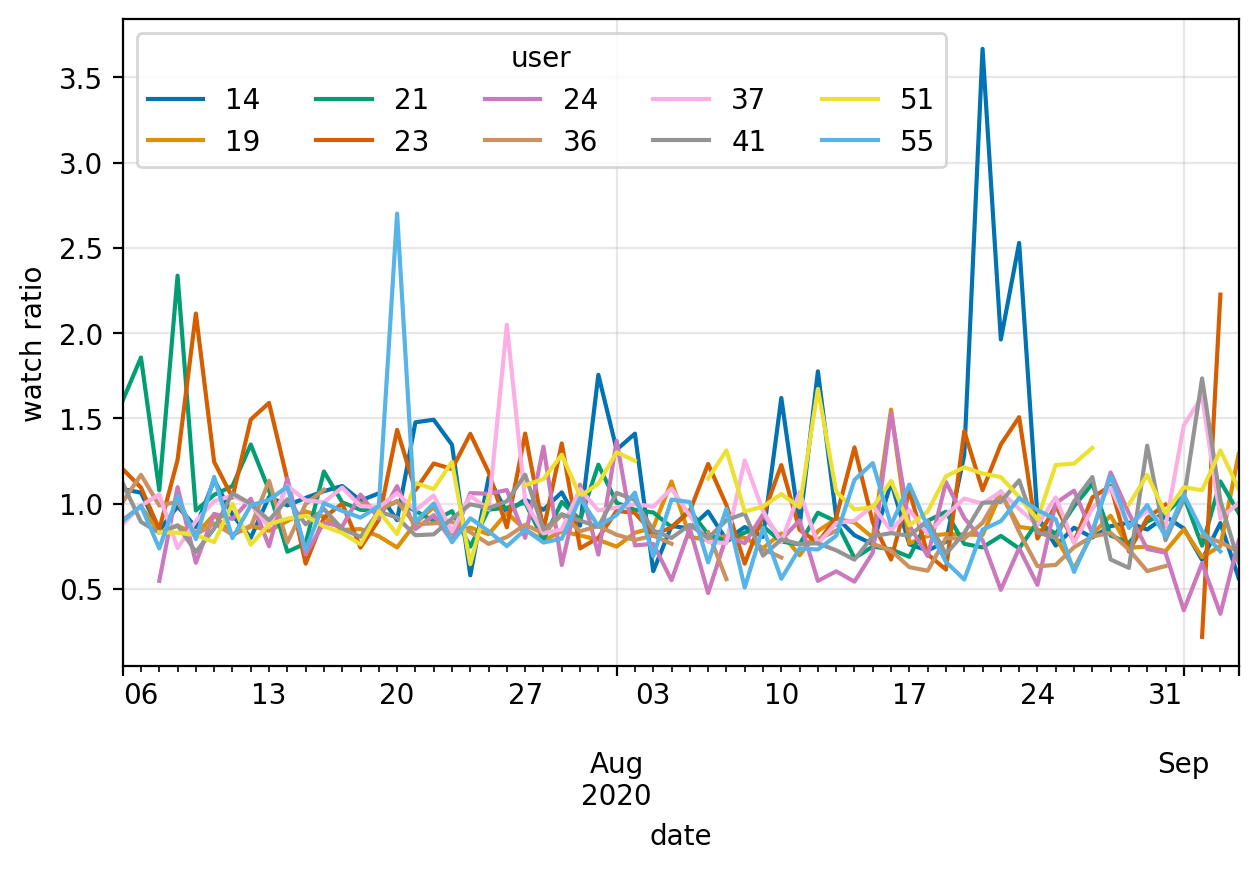

In [15]:
daily_wr = small_matrix_sub.set_index("time").resample("D")["watch_ratio"].mean()

daily_wr = small_matrix_sub.pivot_table(index="date", columns="user_id", values="watch_ratio")
daily_wr.index = pd.to_datetime(daily_wr.index.astype(int).astype(str), yearfirst=format("%Y%m%d"))

daily_wr.iloc[:, :10].plot()
plt.legend(ncol=5, title="user")
plt.ylabel("watch ratio")
plt.grid(alpha=0.3)

## Process dataset

In [17]:
import os
from functools import partial
from multiprocessing import Pool

In [18]:
def parse_batch_users(users, n_arms=5):
    df_batch = []
    for user in users:
        subset = small_matrix_sub.query("user_id == @user")
        n_values = len(subset)
        subset = subset.assign(group=np.arange(n_values) // n_arms)
        
        df_flat = subset.groupby("group").apply(lambda x: x.values.flatten(), include_groups=False).apply(pd.Series)
        df_flat.columns = [f"{col}_{i}" for i in range(n_arms) for col in subset.columns[:-1]]
        df_batch.append(df_flat)
    return df_batch

In [19]:
n_arms = 5
n_cores = os.cpu_count()
users = small_matrix_sub["user_id"].unique()
users_by_batch = np.array_split(users, n_cores)

In [ ]:
%%time
poolfn = partial(parse_batch_users, n_arms=n_arms)
with Pool(n_cores) as pool:
    df_all = pool.map(poolfn, users_by_batch)
df_all = [element for batch in df_all for element in batch]
df_all = pd.concat(df_all, axis=0)
df_all.shape

In [18]:
df_all.head()

,user_id_0,video_id_0,play_duration_0,video_duration_0,time_0,date_0,timestamp_0,watch_ratio_0,like_cnt_0,share_cnt_0,...,play_duration_4,video_duration_4,time_4,date_4,timestamp_4,watch_ratio_4,like_cnt_4,share_cnt_4,play_cnt_4,comment_cnt_4
group,,,,,,,,,,,,,,,,,,,,,
0,14,0,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,3485,72,...,4602.0,11000.0,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,6404.0,23.0,475632.0,339.0
1,14,5,8607,13267,2020-07-05 05:36:00.773,20200705.0,1.593899e+09,0.648753,1463,4,...,8518.0,5217.0,2020-07-05 05:57:26.581,20200705.0,1.593900e+09,1.632739,1859.0,8.0,319541.0,10.0
2,14,10,8614,6334,2020-07-05 06:14:51.500,20200705.0,1.593901e+09,1.359962,710,2,...,8642.0,6067.0,2020-07-05 06:51:24.362,20200705.0,1.593903e+09,1.424427,450.0,85.0,150952.0,26.0
3,14,15,8710,7074,2020-07-05 06:52:26.169,20200705.0,1.593903e+09,1.231269,90,2,...,8543.0,5734.0,2020-07-05 08:18:08.954,20200705.0,1.593908e+09,1.489885,1902.0,23.0,157182.0,101.0
4,14,20,4588,6933,2020-07-05 08:22:10.226,20200705.0,1.593909e+09,0.661763,25537,333,...,4453.0,6850.0,2020-07-05 09:08:13.209,20200705.0,1.593911e+09,0.650073,21.0,1.0,3972.0,1.0


In [19]:
df_all.to_pickle(f"./data/arms_{n_arms:02}_raw.pkl")

# A simple bandit

In [16]:
df_all = pd.read_pickle("./data/arms_05_raw.pkl").dropna()
df_all = df_all.sort_values("time_0")
df_all = df_all.sample(frac=1.0, random_state=31, replace=False)

In [17]:
df_all.head()

,user_id_0,video_id_0,play_duration_0,video_duration_0,time_0,date_0,timestamp_0,watch_ratio_0,like_cnt_0,share_cnt_0,...,play_duration_4,video_duration_4,time_4,date_4,timestamp_4,watch_ratio_4,like_cnt_4,share_cnt_4,play_cnt_4,comment_cnt_4
group,,,,,,,,,,,,,,,,,,,,,
165,2646,135,9869,7600,2020-07-22 02:48:36.589,20200722.0,1.595357e+09,1.298553,764,4,...,9905.0,6943.0,2020-07-22 02:55:52.334,20200722.0,1.595358e+09,1.426617,7339.0,92.0,307547.0,370.0
215,506,1108,5726,6240,2020-07-25 02:21:49.960,20200725.0,1.595615e+09,0.917628,366,3,...,4695.0,12701.0,2020-07-25 02:29:59.960,20200725.0,1.595615e+09,0.369656,4619.0,5.0,271525.0,59.0
18,6376,863,8792,9267,2020-07-08 05:49:00.694,20200708.0,1.594159e+09,0.948743,1131,11,...,3773.0,8534.0,2020-07-08 06:47:57.566,20200708.0,1.594162e+09,0.442114,55295.0,228.0,2404163.0,616.0
468,4778,3311,6788,28075,2020-08-09 15:57:03.633,20200809.0,1.596960e+09,0.241781,62878,35509,...,5726.0,17584.0,2020-08-09 16:03:55.363,20200809.0,1.596960e+09,0.325637,26858.0,2704.0,1600779.0,98.0
229,3949,1559,8760,7534,2020-07-26 09:39:06.251,20200726.0,1.595728e+09,1.162729,1438,3,...,6770.0,10600.0,2020-07-26 12:17:06.631,20200726.0,1.595737e+09,0.638679,7402.0,39.0,221222.0,379.0


In [18]:
import jax
import chex
import jax.numpy as jnp

In [19]:
@chex.dataclass
class Bandit:
    pulls: jax.Array
    values: jax.Array
    eps: float
    alpha: float

    def update(self, arm, reward):
        current_value = self.values[arm]
        current_pulls = self.pulls[arm]

        value_update = self.alpha * reward + (1 - self.alpha) * current_value
        
        values_update = self.values.at[arm].set(value_update)
        pulls_update = self.pulls.at[arm].set(current_pulls + 1)

        return self.replace(
            pulls=pulls_update,
            values=values_update
        )

    
    def pick(self, key, x):
        key_arm, key_eps = jax.random.split(key)
        greedy_choice = self.values[x].argmax()

        is_random = jax.random.bernoulli(key_arm, self.eps)
        random_choice = jax.random.choice(key_eps, len(x)).astype(int)

        arm_choice = greedy_choice * (1 - is_random) + random_choice * is_random
        return arm_choice
        
    
    @classmethod
    def init(cls, n_arms, eps, alpha):
        key = jax.random.PRNGKey(1314)
        # TODO: change for zeros
        values = jnp.zeros(n_arms)
        return Bandit(
            pulls=jnp.zeros(n_arms),
            values=values,
            eps=eps,
            alpha=alpha
        )

In [20]:
class ENV:
    def __init__(self):
        ...

    def pull_and_update(self, key, bel, y, x):
        ixmax = bel.pick(key, x)
        reward = y[ixmax]

        bel = bel.update(x[ixmax], reward)
        return bel, reward

    def scan(self, key, bel, Y, X):
        keys = jax.random.split(key, len(X))
        def _step(bel, xs):
            key, y, x = xs
            bel, reward = self.pull_and_update(key, bel, y, x)
            return bel, reward

        XS = (keys, Y, X)
        bel, rewards = jax.lax.scan(_step, bel, XS)
        return bel, rewards

In [21]:
jnp.set_printoptions(suppress=True, precision=3, linewidth=200)

In [22]:
# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]
X.head()

,video_id_0,video_id_1,video_id_2,video_id_3,video_id_4
group,,,,,
165,135,3249.0,381.0,184.0,860.0
215,1108,1052.0,1028.0,246.0,1133.0
18,863,134.0,182.0,831.0,112.0
468,3311,1650.0,3291.0,2355.0,2336.0
229,1559,1314.0,191.0,618.0,1027.0


In [23]:
X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)
n_obs

897769

In [24]:
n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

### Random bandit

In [25]:
key = jax.random.PRNGKey(314)
env = ENV()

In [26]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=1.0, alpha=0.3)
bel_random, rewards_random = env.scan(key, bandit, Y[:100_000], X[:100_000].astype(int))
rewards_random = np.array(rewards_random)

CPU times: user 1.33 s, sys: 47.1 ms, total: 1.37 s
Wall time: 6.38 s


### Epsilon bandit

In [27]:
%%time
bandit = Bandit.init(n_arms=n_videos, eps=0.001, alpha=0.3)
bel_eps, rewards_eps = env.scan(key, bandit, Y[:100_000], X[:100_000].astype(int))
rewards_eps = np.array(rewards_eps)

CPU times: user 671 ms, sys: 26.1 ms, total: 697 ms
Wall time: 5.84 s


## Eval

In [28]:
rewards = pd.DataFrame({
    "oracle": Y[:100_000].max(axis=1),
    "eps": rewards_eps,
    "random": rewards_random
})

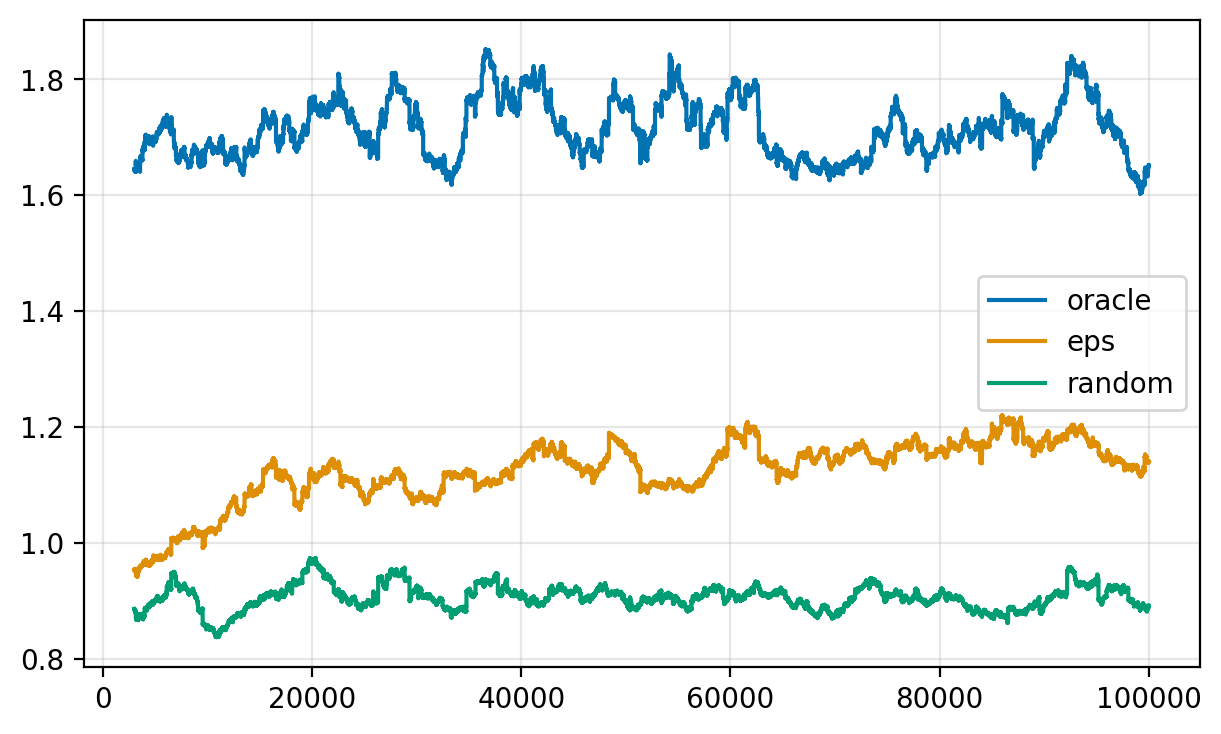

In [29]:
rewards.rolling(window=3_000).mean().plot()
plt.grid(alpha=0.3)

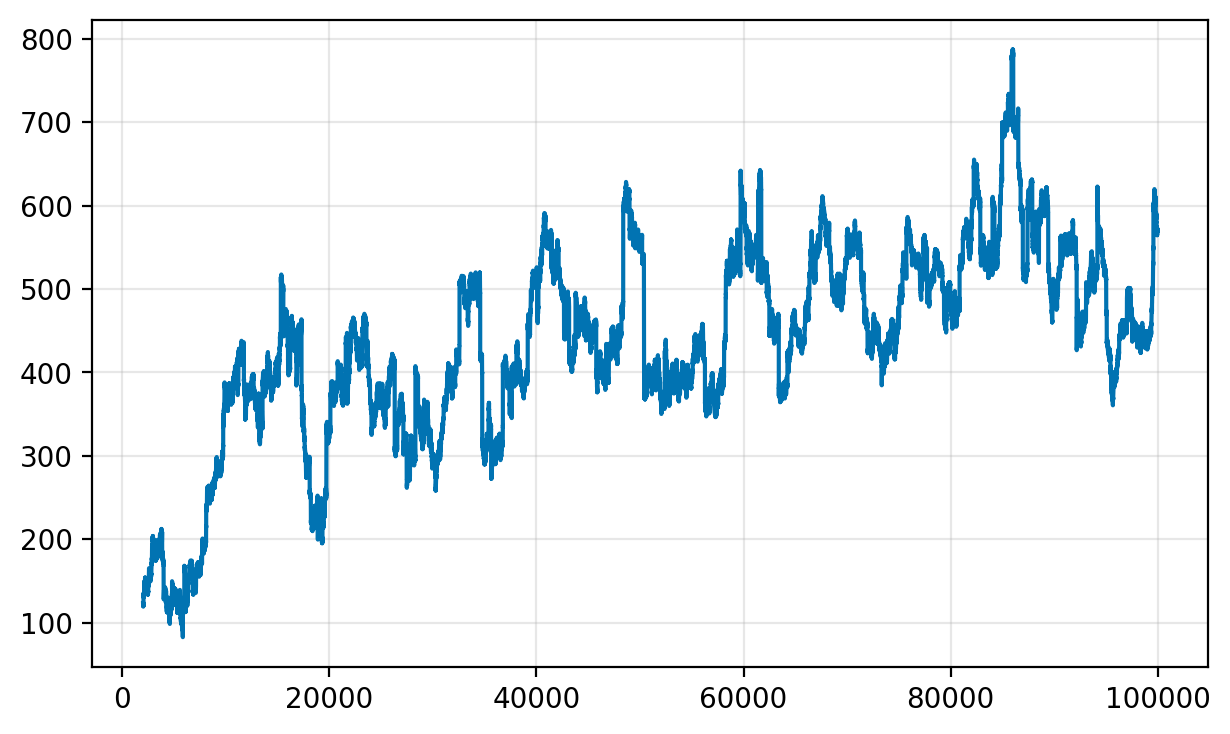

In [30]:
(rewards["eps"] - rewards["random"]).rolling(2_000).sum().plot()
plt.grid(alpha=0.3)

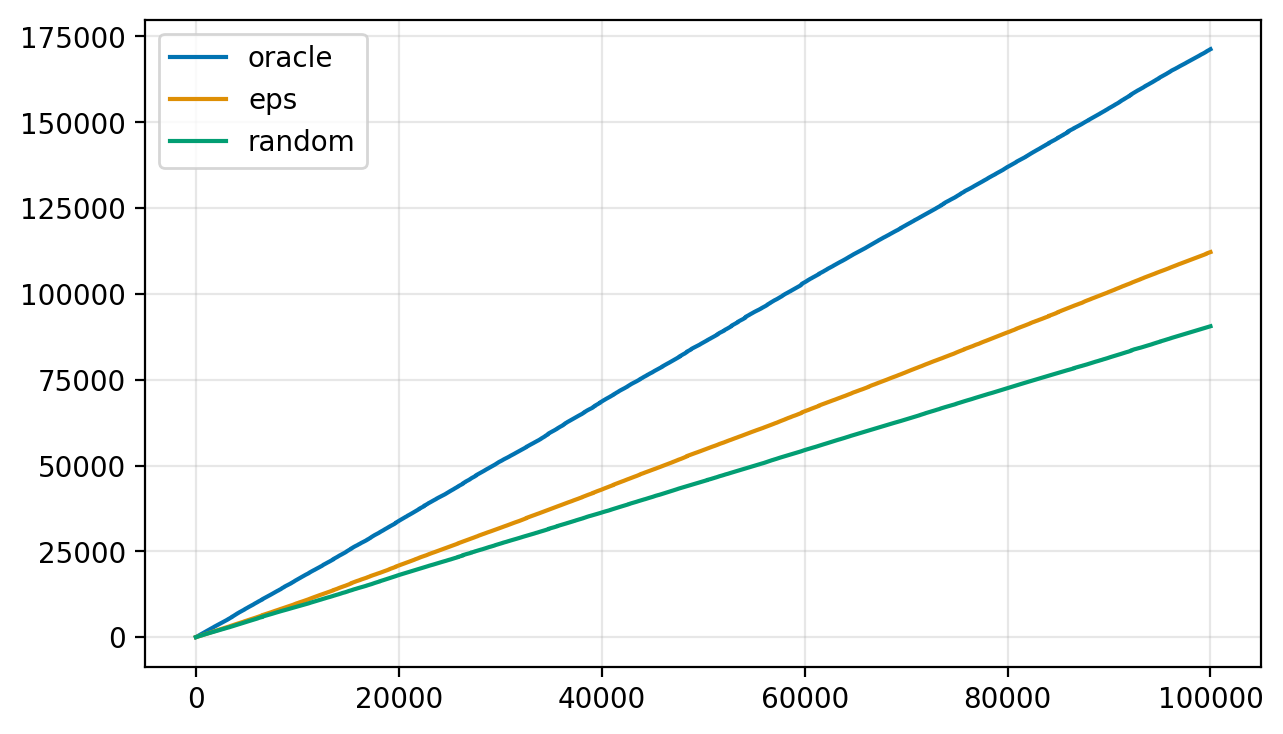

In [31]:
rewards.cumsum().plot()
plt.legend()
plt.grid(alpha=0.3)

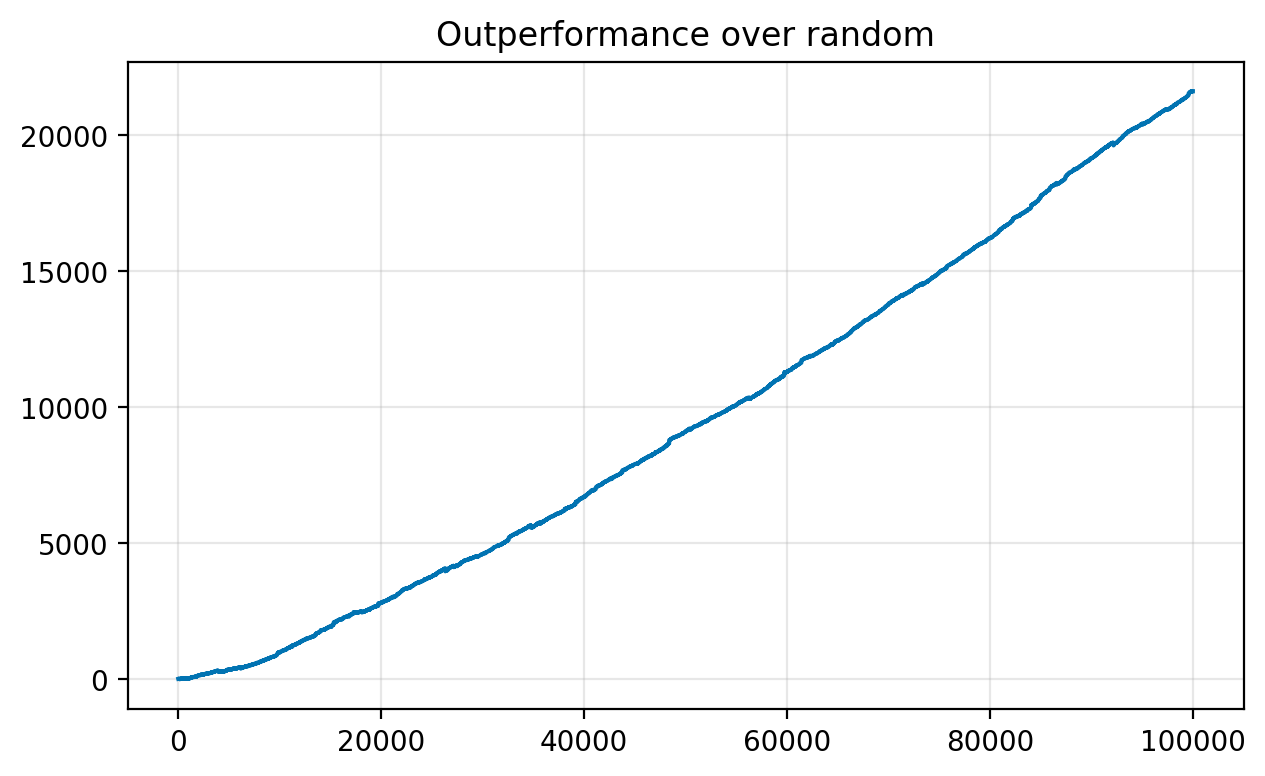

In [32]:
plt.plot((rewards_eps - rewards_random).cumsum())
plt.title("Outperformance over random")
plt.grid(alpha=0.3)

## An $\epsilon$-greedy MLP

In [33]:
import flax.linen as nn

In [34]:
pd.set_option("display.width", 300)

In [35]:
n_arms = 5

In [36]:
target_cols = ["like_cnt", "share_cnt", "play_cnt", "play_duration", "comment_cnt"]
def in_target_cols(column):
    return any([target_col in column for target_col in target_cols])

# We start by building a bandit problem where we are only given the possible arms to pull and the (latent) rewards
X = df_all[[c for c in df_all if ("video_id" in c) or in_target_cols(c)]]
Y = df_all[[c for c in df_all if "watch_ratio" in c]]

X, Y = jax.tree.map(jnp.array, (X, Y))
n_obs = len(X)

n_features = len(target_cols) + 1 # video id and like_cnt
X = X.reshape(-1, n_arms, n_features)

X = X.at[..., 1:].set(jnp.log1p(X[..., 1:]))

n_videos = len(small_matrix_sub["video_id"].unique())
bandit_map = Bandit(pulls=0, values=0, eps=None, alpha=None)

In [37]:
class FeatureExtractor(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x_embedding = nn.Embed(self.n_videos, self.embedding_dim)(x[..., 0].astype(int))
        x_features = nn.Dense(self.dense_dim)(x[..., 1:])
        x = jnp.concat([x_embedding, x_features], axis=-1)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x


class MLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int

    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = nn.Dense(1, name="last_layer")(x) # reward
        return x

## Run experiment

In [38]:
from time import time
from functools import partial

In [39]:
from rebayes_mini.methods import low_rank_last_layer as flores
from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_filter as lofi

In [40]:
key = jax.random.PRNGKey(3141)
mlp = MLP(n_videos=n_videos, embedding_dim=10, dense_dim=10, n_hidden=50)
key_init, key_run = jax.random.split(key)
params_init = mlp.init(key_init, X[0, 0])    

In [41]:
def step(state, xs, agent):
    bel, key = state
    yt, xt = xs
    n_arms = xt.shape[0]
    key_sample, key_update = jax.random.split(key, 2)

    bel = agent.predict(bel)

    keys_sample = jax.random.split(key_sample, n_arms)
    rewards_est = jax.vmap(agent.sample_predictive, in_axes=(0, None, 0))(keys_sample, bel, xt)
    
    # Choose the arm to pull
    arm = rewards_est.argmax()
    
    reward_obs = yt[arm]
    x_pulled = xt[arm]

    bel_update = agent.update(bel, reward_obs, x_pulled)
    state_update = (bel_update, key_update)
    return state_update, reward_obs

## Flores

In [61]:
def cov_fn(y): return jnp.eye(1) * 1e-3
agent = flores.LowRankLastLayer(mlp.apply, cov_fn, rank=20, dynamics_hidden=0.0, dynamics_last=0.0)


print("Running agent with Flores")
bel_init = agent.init_bel(params_init, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:100_000]), X[:100_000])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_flores = jax.lax.scan(_step, state_init, XS)
rewards_flores = np.exp(np.array(rewards_flores)) - 1
time_end = time()

print(rewards_flores.sum())
print(f"Running time {time_end - time_init:.2f}", end=2*"\n")

Running agent with Flores
150951.6
Running time 28.68



## En Flores

In [101]:
from rbpf_flores import LowRankLastLayerEnsemble

In [ ]:
def cov_fn(y): return jnp.eye(1) * 1e-5
agent = LowRankLastLayerEnsemble(mlp.apply, cov_fn, rank=5, dynamics_hidden=0.0, dynamics_last=0.0, num_particles=5)

print("Running agent with Ensemble Flores")
bel_init = agent.init_bel(params_init, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:200_000]), X[:200_000])
_step = partial(step, agent=agent)
time_init = time()
(bel_final, _), rewards_flores_en = jax.lax.scan(_step, state_init, XS)
rewards_flores_en = np.exp(np.array(rewards_flores_en)) - 1
time_end = time()

print(rewards_flores_en.sum())
print(f"Running time {time_end - time_init:.2f}", end=2*"\n")

Running agent with Ensemble Flores


## LRKF

In [85]:
%%time
def cov_fn(y): return jnp.eye(1) * 1e-4
agent = lrkf.LowRankCovarianceFilter(mlp.apply, cov_fn, dynamics_covariance=0.0, rank=5)

bel_init = agent.init_bel(params_init, cov=1.0, low_rank_diag=False)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:100_000]), X[:100_000])
_step = partial(step, agent=agent)
(bel_final, _), rewards_lrkf = jax.lax.scan(_step, state_init, XS)
rewards_lrkf = np.exp(np.array(rewards_lrkf)) - 1

CPU times: user 9.16 s, sys: 112 ms, total: 9.27 s
Wall time: 31.8 s


In [86]:
rewards_lrkf.sum()

np.float32(91811.62)

## LoFi

In [239]:
%%time
def cov_fn(y): return jnp.eye(1) * 0.32 ** 2
agent = lofi.LowRankPrecisionFilter(mlp.apply, cov_fn, dynamics_covariance=1e-6, rank=50)

bel_init = agent.init_bel(params_init, cov=0.1)
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:100_000]), X[:100_000])
# XS = (jnp.log1p(Y[:10_000]), X[:10_000])
_step = partial(step, agent=agent)
(bel_final, _), rewards_lofi = jax.lax.scan(_step, state_init, XS)
rewards_lofi = np.exp(np.array(rewards_lofi)) - 1

CPU times: user 7.23 s, sys: 168 ms, total: 7.4 s
Wall time: 1min 45s


## VBLL

In [42]:
import optax
from vbll_fifo import Regression, FifoVBLL, RegressionRefac
from bayesopt import test_functions, eval_fn, agents

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
class VBLLMLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int
    wishart_scale: float = 0.01
    regularization_weight: float = 1.0


    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=self.wishart_scale,
            regularization_weight=self.regularization_weight,
            name="last_layer",
        )(x)
        return x

learning_rate = 1e-3
buffer_size = 5
n_inner = 5
vbl_mlp = VBLLMLP(n_videos=n_videos, embedding_dim=10, n_hidden=10, dense_dim=10)
params_init_vbll = vbl_mlp.init(key_init, X[0,0])

def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

dim = X.shape[-1]

agent = FifoVBLL(
    vbl_mlp.apply,
    lossfn,
    tx=optax.adamw(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim,
    dim_output=1,
    n_inner=n_inner,
)

In [ ]:
print("Running agent with VBLL")
bel_init = agent.init_bel(params_init_vbll)

time_init = time()
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:50_000]), X[:50_000])
_step = partial(step, agent=agent)
(bel_final, _), rewards_vbll_fifo = jax.lax.scan(_step, state_init, XS)
rewards_vbl_fifo = np.exp(np.array(rewards_vbll_fifo)) - 1
time_end = time()

print(rewards_vbll_fifo.sum())
print(f"Running time {time_end - time_init:0.2f}")

Running agent with VBLL


## Flores+VBLL

In [58]:
%reload_ext autoreload
%autoreload 2

In [59]:
from rbpf_flores import VBLLFlores

In [60]:
class FVBLLMLP(nn.Module):
    n_videos: int
    embedding_dim: int
    dense_dim: int
    n_hidden: int
    wishart_scale: float = 0.01
    regularization_weight: float = 1.0


    @nn.compact
    def __call__(self, x):
        x = FeatureExtractor(self.n_videos, self.embedding_dim, self.dense_dim, self.n_hidden)(x)
        x = RegressionRefac(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=self.wishart_scale,
            regularization_weight=self.regularization_weight,
            name="last_layer",
        )(x)
        return x

learning_rate = 1e-3
vbl_mlp = FVBLLMLP(n_videos=n_videos, embedding_dim=10, n_hidden=10, dense_dim=10)
params_init_vbll = vbl_mlp.init(key_init, X[0,0])

In [61]:
def vbll_loss(params, x, y):
    res = vbl_mlp.apply(params, x)
    loss = res.train_loss_fn(y)
    return jnp.atleast_1d(loss)

In [63]:
agent = VBLLFlores(
    vbl_mlp.apply,
    vbll_loss,
    rank=20,
    dynamics_hidden=0.0,
    dynamics_last=0.0
)
bel_init = agent.init_bel(params_init_vbll)

In [64]:
%%time
print("Running agent with Flores+VBLL")
bel_init = agent.init_bel(params_init_vbll)

time_init = time()
state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:50_000]), X[:50_000])
_step = partial(step, agent=agent)
(bel_final, _), rewards_vbll_flores = jax.lax.scan(_step, state_init, XS)
rewards_vbll_flores = np.exp(np.array(rewards_vbll_flores)) - 1
time_end = time()

print(rewards_vbll_flores.sum())
print(f"Running time {time_end - time_init:0.2f}")

Running agent with Flores+VBLL
(1, 33760)
(1, 122)
45439.086
Running time 19.33
CPU times: user 3.55 s, sys: 187 ms, total: 3.73 s
Wall time: 19.3 s


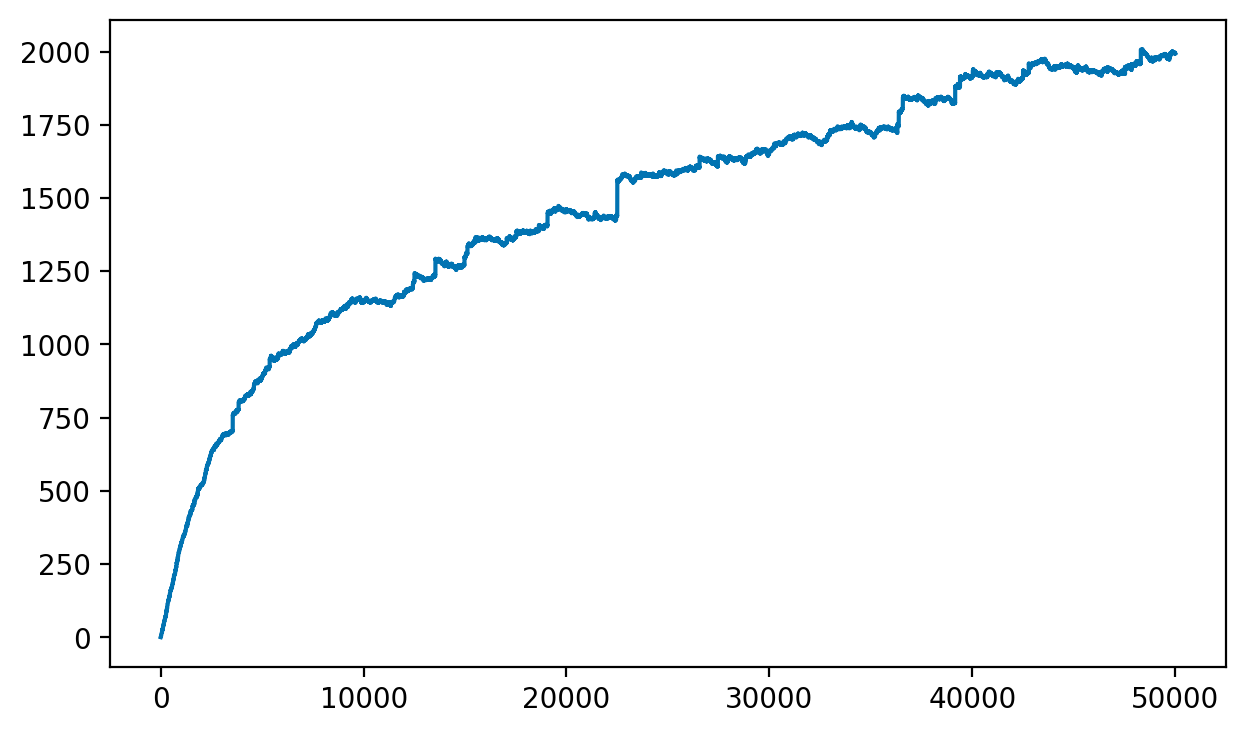

In [65]:
plt.plot(rewards_vbll_flores.cumsum() - rewards_vbll_fifo.cumsum())

## Results

In [65]:
rewards = pd.DataFrame({
    "oracle": Y[:50_000].max(axis=1),
    # "flores": rewards_flores,
    # "flores_en": rewards_flores_en,
    "vbll": rewards_vbll_fifo,
    "vbll_flores": rewards_vbll_flores,
    # "lrkf": rewards_lrkf,
    # "lofi": rewards_lofi,
    # "eps": rewards_eps,
    # "random": rewards_random
}, index=df_all["time_0"][:50_000])

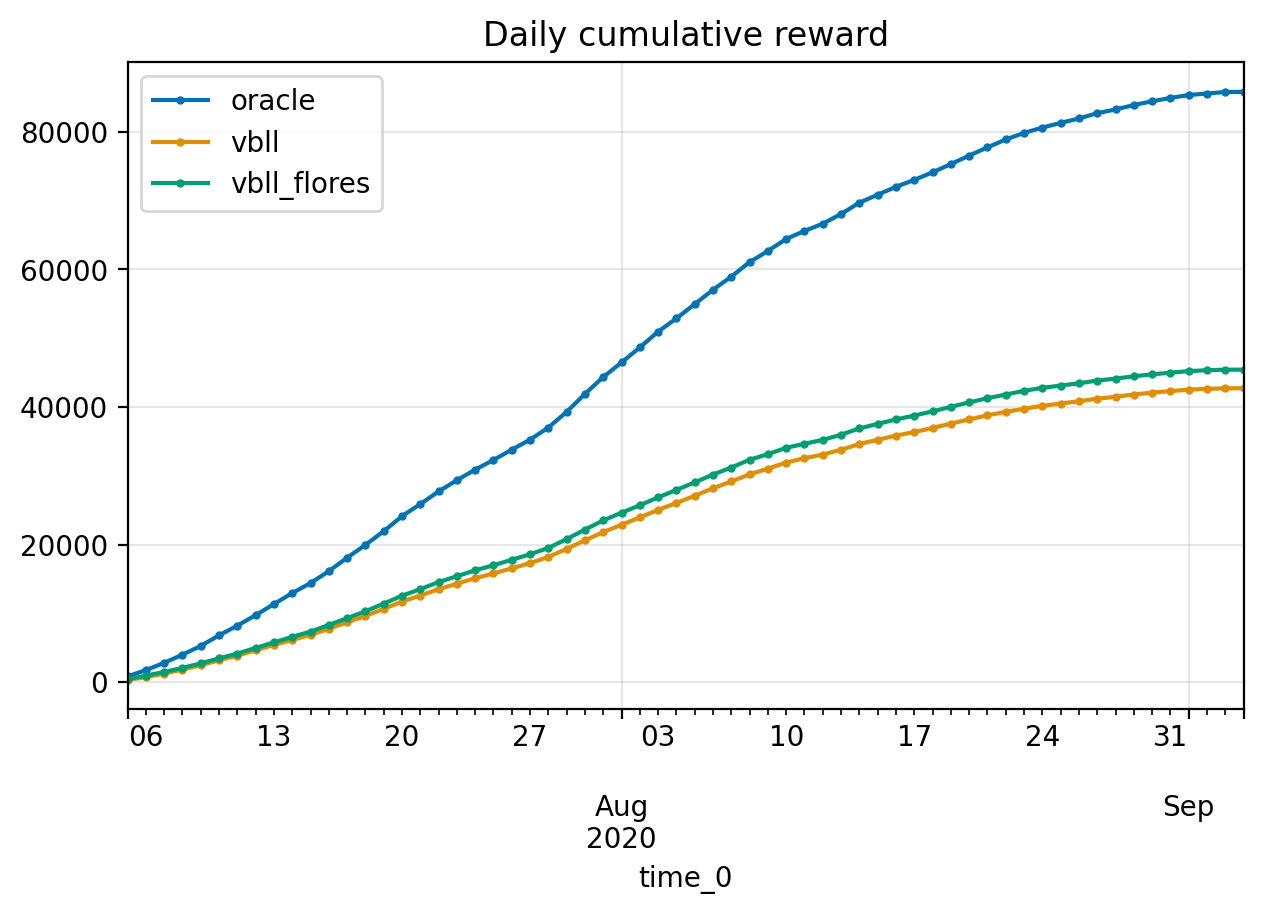

In [66]:
rewards.resample("D").sum().cumsum().plot(marker="o", markersize=2)
plt.title("Daily cumulative reward")
plt.grid(alpha=0.3)

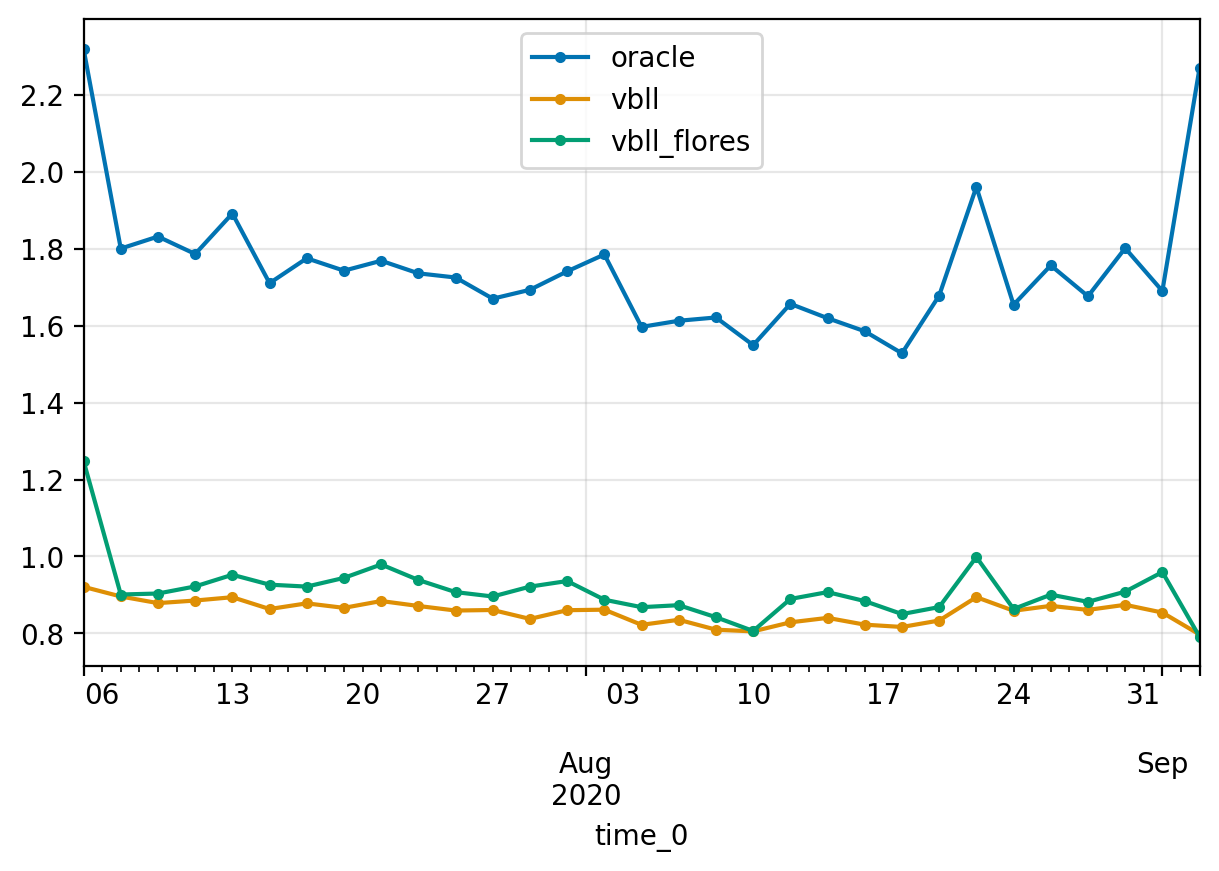

In [67]:
rewards.resample("2D").mean().plot(marker="o", markersize=3)
plt.grid(alpha=0.3)

In [68]:
rewards.resample("D").mean().describe()

,oracle,vbll,vbll_flores
count,62.000000,62.000000,62.000000
mean,1.733889,0.854163,0.911411
std,0.204635,0.045634,0.084290
min,1.121382,0.614302,0.752601
25%,1.616198,0.831729,0.868895
50%,1.727916,0.861580,0.901528
75%,1.796031,0.880308,0.926836
max,2.486816,0.971040,1.251853


## Replay buffer test

In [116]:
from functools import partial

In [117]:
from rbpf_flores import LowRankLastLayerReplay

In [132]:
def step_bone(state, xs, agent):
    bel, key = state
    yt, xt = xs
    key_sample, key_update = jax.random.split(key, 2)

    bel = agent.predict(bel)

    keys_sample = jax.random.split(key_sample, n_arms)
    rewards_est = jax.vmap(agent.sample_predictive, in_axes=(0, None, 0))(keys_sample, bel, xt)
    
    # Choose the arm to pull
    arm = rewards_est.argmax()
    
    reward_obs = yt[arm]
    x_pulled = xt[arm]

    bel_update = agent.update(bel, reward_obs, x_pulled)
    state_update = (bel_update, key_update)
    
    return state_update, (reward_obs, bel.runlength, bel.log_posterior)

In [138]:
%%time
def cov_fn(y): return jnp.eye(1) * 0.32  ** 2
agent = LowRankLastLayerReplay(
    mlp.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
    buffer_size=1, p_change=1e-5
)

bel_init = agent.init_bel(
    params_init, cov_hidden=1.0, cov_last=1.0, low_rank_diag=False,
    dim_in=6, dim_obs=1
)


state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:1_000]), X[:1_000])
_step = partial(step_bone, agent=agent)
(bel_final, _), (rewards_flores_oupr, runlength, log_posterior) = jax.lax.scan(_step, state_init, XS)
rewards_flores_oupr = np.exp(np.array(rewards_flores_oupr)) - 1

CPU times: user 6.86 s, sys: 295 ms, total: 7.16 s
Wall time: 4.44 s


In [139]:
rewards_flores_en[:50_000].sum()

np.float32(76076.88)

In [140]:
rewards_flores.sum()

np.float32(45436.07)

In [141]:
r = pd.DataFrame({
    "vbll": rewards_vbll[:50_000],
    "flores": rewards_flores
})

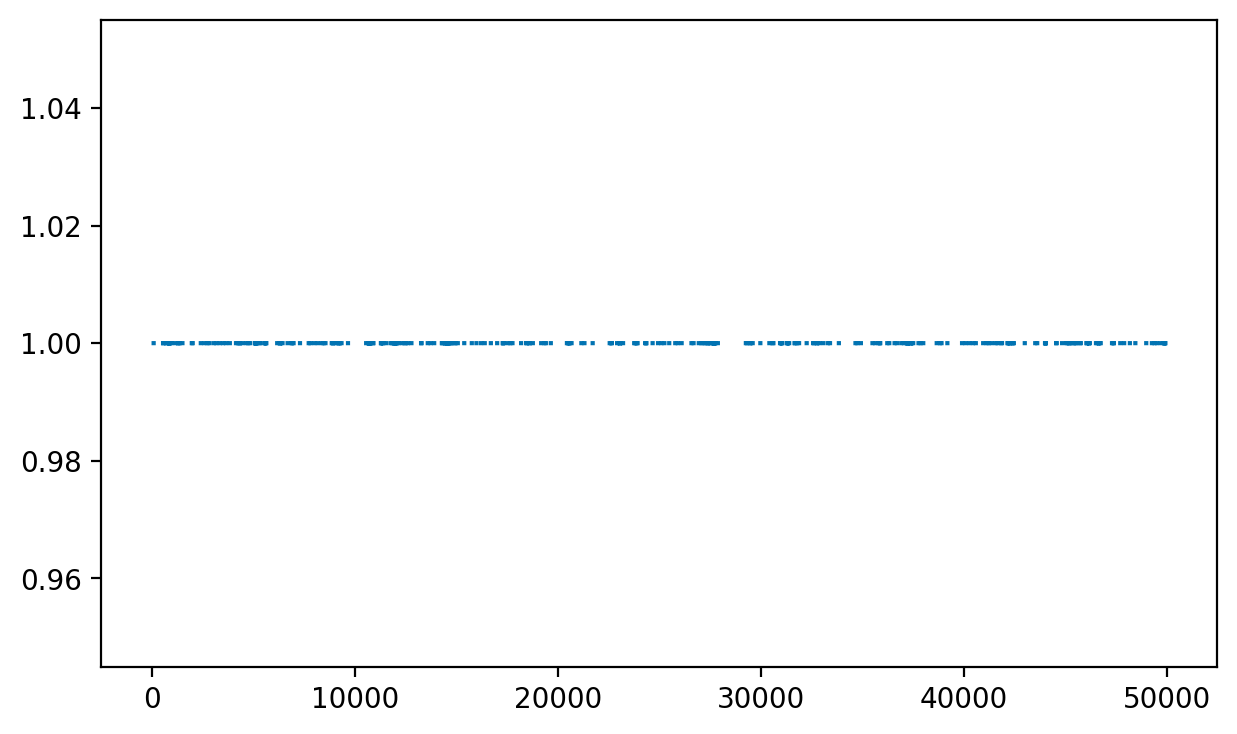

In [125]:
plt.plot(jnp.exp(log_posterior))

<Axes: >

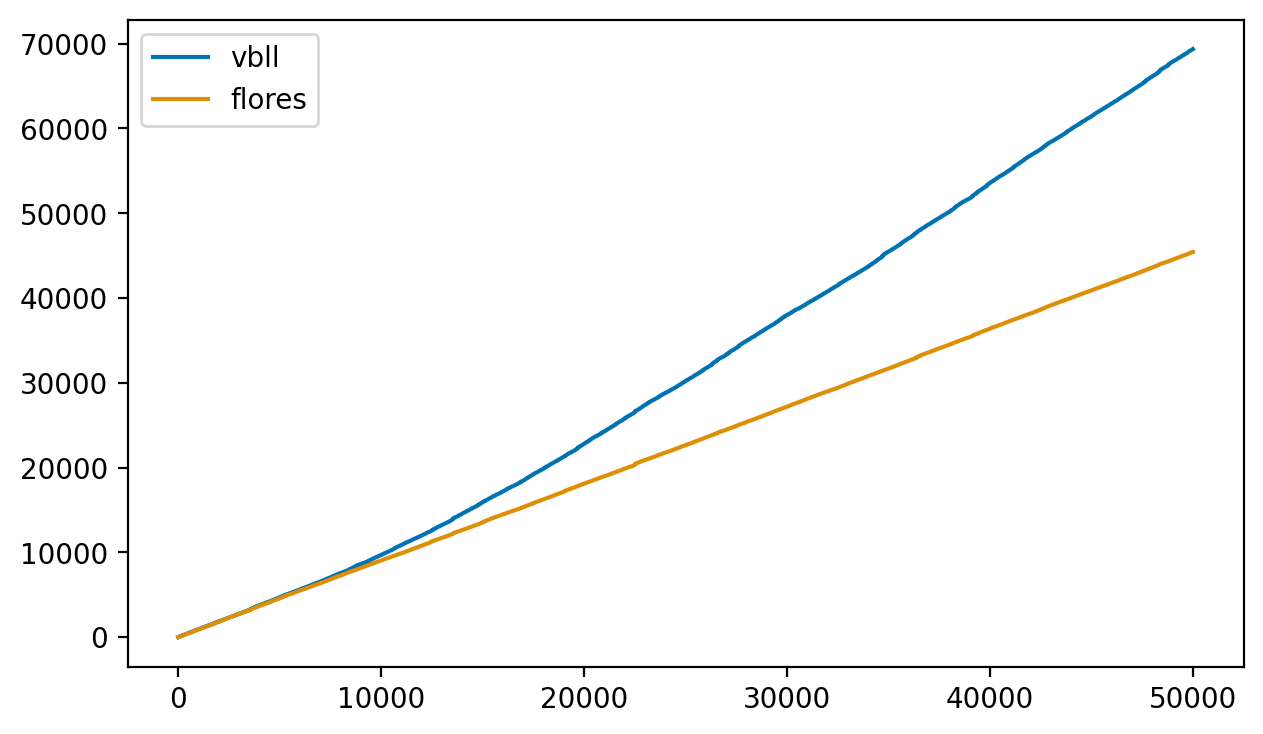

In [126]:
r.cumsum().plot()

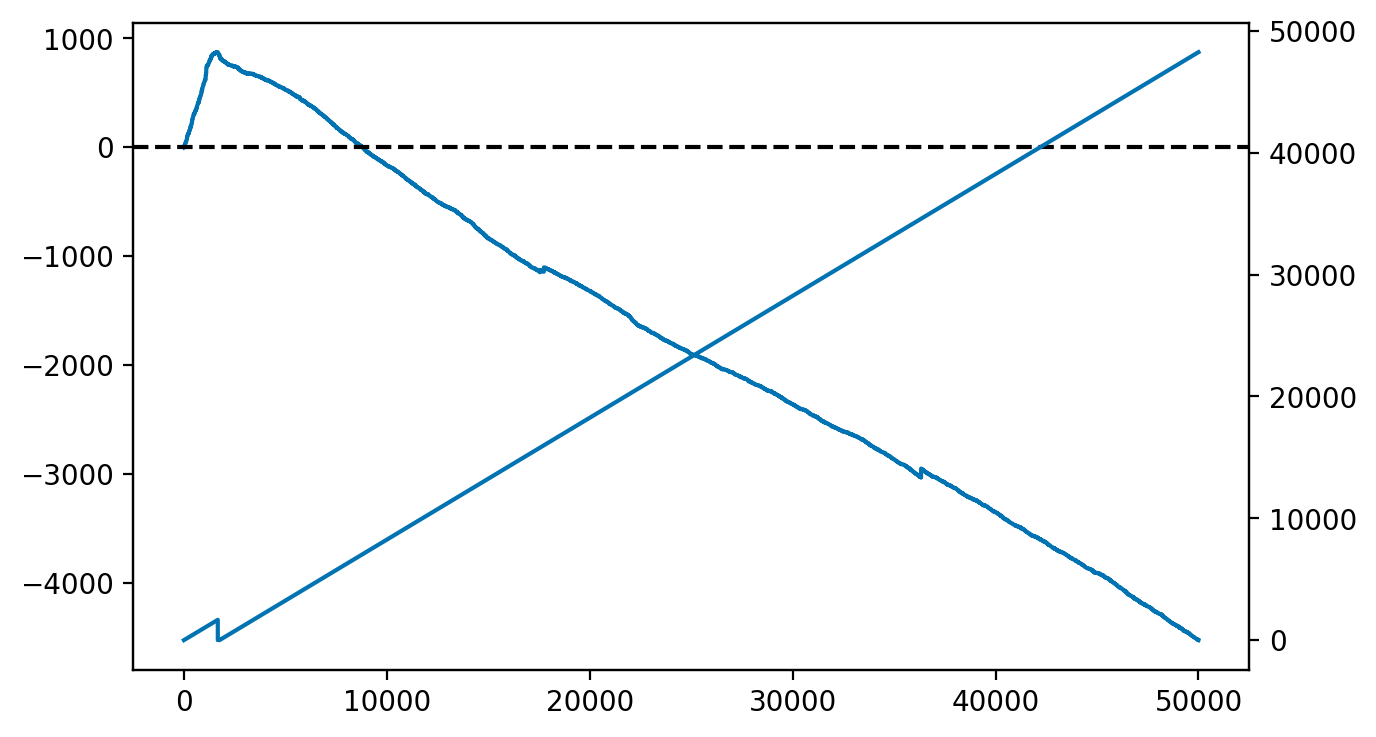

In [412]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
(r.cumsum()["flores"] - r.cumsum()["vbll"]).plot(ax=ax)
ax.axhline(y=0.0, c="black", linestyle="--")
ax2.plot(runlength)

## Flores with inverse Gamma

In [143]:
from rbpf_flores import LowRankLastLayerGamma

In [144]:
def step(state, xs, agent):
    bel, key = state
    key_params, key_noise = jax.random.split(key)
    yt, xt = xs
    arms = xt[:, 0].astype(int)

    bel = agent.predict(bel)

    fn = agent.sample_fn(key_params, bel)
    noise = jnp.sqrt(bel.beta.at[arms].get() / (bel.alpha.at[arms].get() - 1))
    noise = jax.random.normal(key_noise, (len(arms))) * noise
    reward_est = fn(xt) + noise
    
    # Choose the arm to pull
    arm = reward_est.argmax()
    
    reward_obs = yt[arm]
    x_pulled = xt[arm]

    _, key_update = jax.random.split(key)
    bel_update = agent.update(bel, reward_obs, x_pulled)
    state_update = (bel_update, key_update)
    return state_update, reward_obs

In [150]:
%%time
agent = LowRankLastLayerGamma(
    mlp.apply, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    num_arms=n_videos,
    params=params_init,
    alpha_prior=10, beta_prior=0.1,
    cov_hidden=1.0, cov_last=1.0, low_rank_diag=False,
)

state_init = (bel_init, key_run)
XS = (jnp.log1p(Y[:100_000]), X[:100_000])
_step = partial(step, agent=agent)
(bel_final, _), rewards_flores = jax.lax.scan(_step, state_init, XS)
rewards_flores = np.exp(np.array(rewards_flores)) - 1

CPU times: user 3.83 s, sys: 157 ms, total: 3.99 s
Wall time: 28.3 s


In [151]:
rewards_flores.sum()

np.float32(144251.25)

In [152]:
r = pd.DataFrame({
    "vbll": rewards_vbll,
    "flores": rewards_flores
}) 

<Axes: >

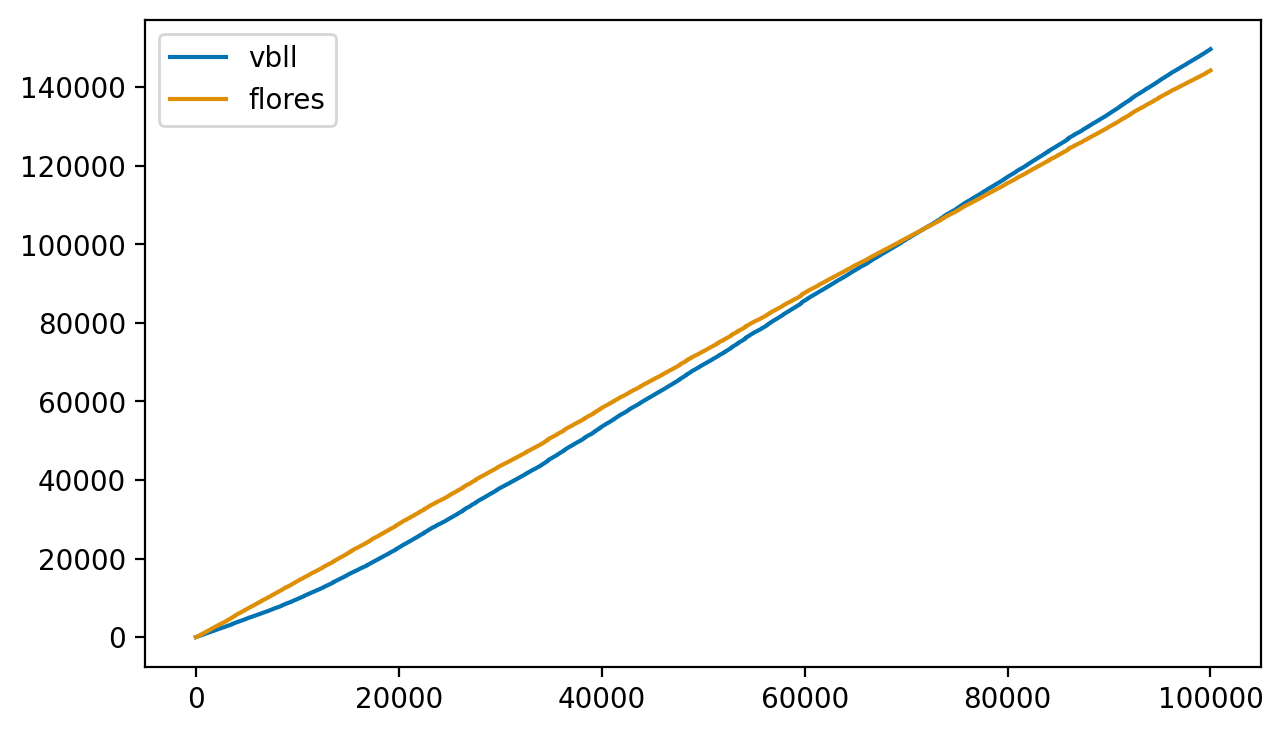

In [153]:
r.cumsum().plot()